In [1]:
# Import libraries
import moments, moments.LD
import pandas as pd, numpy as np
from collections import defaultdict

import demes, demesdraw, matplotlib.pylab as plt
import model, slice, get_LD

[Split(parent='Ancestral', children=['Split_02', 'Split_00', 'Split_01'], time=12000.0), Split(parent='Merge_1', children=['Split_11', 'Split_10', 'Split_12'], time=6000.0)]


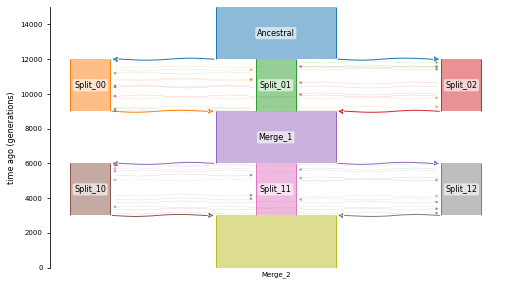

In [54]:
N = 30e3
time_period = 0.1*N
#cake = model.cake_model(Ns=[N,N,N],splits = [3,3],proportions=[[0.6,0.2,0.2],[0.6,0.2,0.2]],time_period_merge=[time_period,time_period,time_period],time_period_splits=[time_period,time_period])
cake = model.cake_model(Ns=[N,N,N],splits = [3,3],proportions=[[1/3,1/3,1/3],[1/3,1/3,1/3]],time_period_merge=[time_period,time_period,time_period],time_period_splits=[time_period,time_period])

In [55]:
times,times_dic = slice.sample_timepoints(cake)

In [56]:
sliced_dict = slice.slice_timepoints(cake,times)

<AxesSubplot:ylabel='time ago (generations)'>

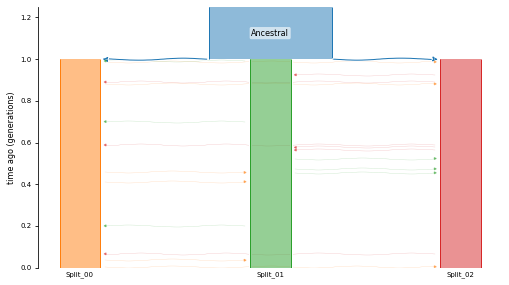

In [57]:
demesdraw.tubes(sliced_dict[11999], log_time=False, num_lines_per_migration=3)

<AxesSubplot:ylabel='time ago (generations)'>

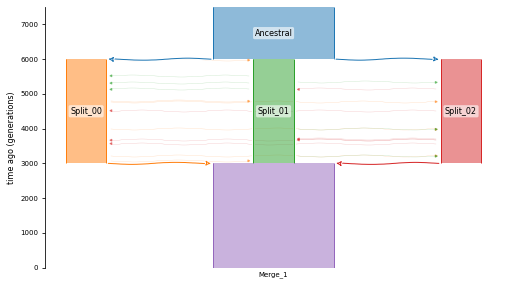

In [50]:
demesdraw.tubes(sliced_dict[6001], log_time=False, num_lines_per_migration=3)

In [58]:
def Dstat(graph,sampled_demes,rhos,norm_pop_idx=0,sample_times = None):
     if sample_times is None:
          sample_times = np.zeros(len(sampled_demes))
     y = moments.Demes.LD(graph, sampled_demes=sampled_demes, sample_times=sample_times,rho = rhos)
     sigma = moments.LD.Inference.sigmaD2(y,normalization=norm_pop_idx)
     return sigma


In [8]:
sliced_dict.keys()

dict_keys([1.0, 1500.0, 2999.0, 3001.0, 4500.0, 5999.0, 6001.0, 7500.0, 8999.0, 9001.0, 10500.0, 11999.0, 12001.0, 14000.0, 16000.0])

In [9]:
D = sliced_dict[2999]

In [10]:
[deme.epochs[0].start_size for deme in sliced_dict[2999].demes]

[30000.0, 18000.0, 6000.0, 6000.0, 30000.0, 18000.0, 6000.0, 6000.0, 30000.0]

In [43]:
# set up recombination rates
rhos = np.logspace(-2, 2, 21)

def get_LD_from_sliced_demes(sliced_dict,rhos = np.logspace(-2, 2, 21)):
    LD_dictionary = defaultdict(list)
    for sliced in sliced_dict:
        alive = [deme.name for deme in sliced_dict[sliced].demes if deme.end_time == 0 ]
        sizes = [deme.epochs[0].start_size for deme in sliced_dict[sliced].demes if deme.end_time == 0 ]
        norm_idx = sizes.index(max(sizes))
        sigma = Dstat(sliced_dict[sliced], sampled_demes=alive, rhos = rhos, norm_pop_idx=norm_idx)
        for deme,i in zip(alive,range(len(alive))):
            DD = 'DD_'+str(i)+"_"+str(i)
            Dz = 'Dz_'+str(i)+"_"+str(i)+"_"+str(i)
            pi = 'pi2_'+str(i)+"_"+str(i)+"_"+str(i)+"_"+str(i)
            sigmapop = sigma.LD()[:,[sigma.names()[0].index(stat) for stat in [DD,Dz,pi]]]
            LD_dictionary[deme].append(sigmapop)
    return LD_dictionary

In [59]:
LD_dict = get_LD_from_sliced_demes(sliced_dict)

normalizing by Merge_2
normalizing by Merge_2
normalizing by Merge_2
normalizing by Split_10
normalizing by Split_10
normalizing by Split_10
normalizing by Merge_1
normalizing by Merge_1
normalizing by Merge_1
normalizing by Split_00
normalizing by Split_00
normalizing by Split_00
normalizing by Ancestral
normalizing by Ancestral
normalizing by Ancestral


In [45]:
LD_dict.keys()

dict_keys(['Merge_2', 'Split_10', 'Split_11', 'Split_12', 'Merge_1', 'Split_00', 'Split_01', 'Split_02', 'Ancestral'])

In [38]:
LD_dict['Split_02'][0][:,0]

array([0.48202762, 0.48078217, 0.47882266, 0.47575267, 0.47097459,
       0.46361393, 0.45245208, 0.43592375, 0.41228992, 0.38012911,
       0.33918404, 0.29123127, 0.24021031, 0.19106127, 0.1478398 ,
       0.11245971, 0.08474781, 0.06334827, 0.046702  , 0.0336592 ,
       0.02358583])

In [61]:

def plot_LD(LD_sigma, rhos, times_dic, ancestral, plot_file = None, figsize = (10,20)):
    fig = plt.figure(constrained_layout=True, figsize = figsize)
    subfigs = fig.subfigures(nrows=len(LD_sigma.keys()), ncols=1)

    for pop,subfig in zip(LD_sigma,subfigs):
        subfig.suptitle(pop)
        (ax1, ax2, ax3) = subfig.subplots(nrows=1, ncols=len(LD_sigma[pop]))
        for time_point in range(len(LD_sigma[pop])):
            ax1.plot(rhos, LD_sigma[pop][time_point][:, 0],label=str("tp_"+str(times_dic[pop][time_point])))
            ax2.plot(rhos, LD_sigma[pop][time_point][:, 1],label=str("tp_"+str(times_dic[pop][time_point])))
            ax3.plot(rhos, LD_sigma[pop][time_point][:, 2],label=str("tp_"+str(times_dic[pop][time_point])))
        
        ax1.plot(rhos, ancestral[:, 0],'k--',label="Ancestral",linewidth = 1,alpha = 0.7)
        ax2.plot(rhos, ancestral[:, 1],'k--',label="Ancestral",linewidth = 1,alpha = 0.7)
        ax3.plot(rhos, ancestral[:, 2],'k--',label="Ancestral",linewidth = 1,alpha = 0.7)
    
        ax1.set_yscale("log")
        ax2.set_yscale("log")
        ax3.set_yscale("log")
        ax1.set_xscale("log")
        ax2.set_xscale("log")
        ax3.set_xscale("log")
        ax1.set_xlabel(r"$\rho$")
        ax2.set_xlabel(r"$\rho$")
        ax3.set_xlabel(r"$\rho$")
        ax1.set_ylabel(r"$\sigma_d^2$")
        ax2.set_ylabel(r"$\sigma_{Dz}$")
        ax3.set_ylabel(r"Pi2")

        ax1.legend()
        #ax2.legend()
        #ax3.legend()
    if plot_file != None :
        plt.savefig(plot_file,format='svg',transparent = False)

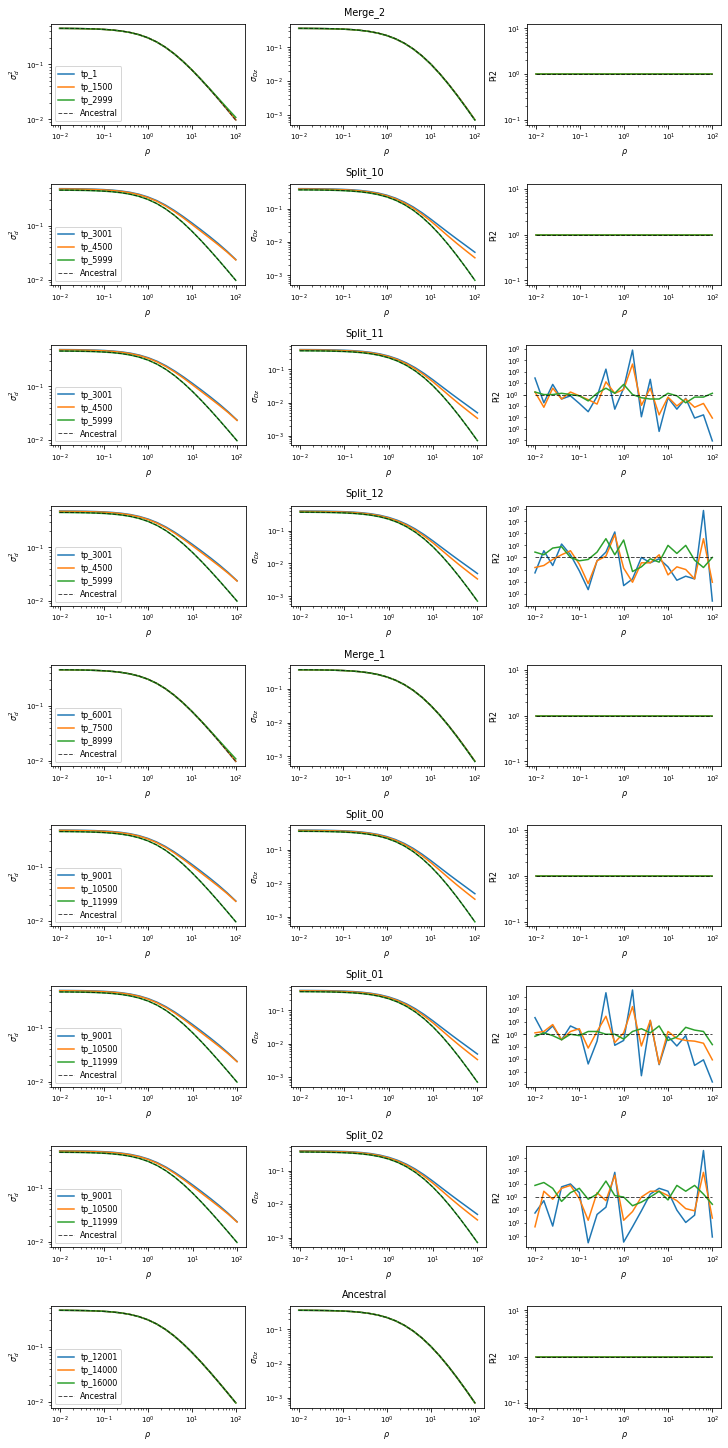

In [62]:
plot_LD(LD_dict,rhos,times_dic,LD_dict['Ancestral'][0],plot_file="plot_trial.svg")